# Aculei notebook

This notebook is a collection of visuals to better understand the aculei dataset.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

rc={
    'axes.titlesize' : 14,
    'figure.figsize' : (12, 6),
    'legend.fontsize' : 10,
    'lines.linewidth' : 1.0,
    'lines.markersize' : 5.0,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
}

palette = ["#090364", "#091e75", "#093885", "#085396", "#086da6", 
           "#0888b7", "#08a2c7", "#07bdd8", "#07d7e8", "#07f2f9", 
           "#f9ac07", "#c77406", "#963b04", "#640303"]

sns.set_theme(context='notebook', style='whitegrid', palette=sns.color_palette(), rc=rc)

In [2]:
data_folder = 'data/'
image_folder = 'images-compressed/'
d_archive = pd.read_csv(os.path.join(data_folder, 'archive.csv'))
d_experience = pd.read_csv(os.path.join(data_folder, 'experience.csv'))

df = pd.concat([d_archive, d_experience], ignore_index=False).reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                988 non-null    object 
 1   image_name        988 non-null    object 
 2   predicted_animal  988 non-null    object 
 3   moon_phase        971 non-null    object 
 4   temperature       484 non-null    float64
 5   date              971 non-null    object 
 6   cam               847 non-null    object 
 7   top_predictions   988 non-null    object 
dtypes: float64(1), object(7)
memory usage: 61.9+ KB


Filter out crazy temperatures and add month column

In [4]:
df.temperature = df.temperature.apply(lambda x: x if x > -10 and x < 40 else None)

df.date = pd.to_datetime(df.date)

df['cam'] = df.cam.astype(str)
df['cam'] = df.cam.apply(lambda x: x.replace(' ', ''))

In [5]:
df.head()

,id,image_name,predicted_animal,moon_phase,temperature,date,cam,top_predictions
0,76288dfbf134376e0b6fae8d8ff87c26,TF_ACULEI_25012021-203.jpg,porcupine,Waxing Gibbous,17.0,2021-01-25 02:01:32,CAM7,"[{'score': 0.9460213780403137, 'label': 'porcu..."
1,b208189a2c8098e96b6fcd072c11973b,TF_ACULEI_09122022-20472.jpg,badger,Full Moon,NaN,2022-12-09 00:26:36,CAM7,"[{'score': 0.5541021227836609, 'label': 'badge..."
2,565a665ece3a28a303341f0bad2438a3,TF_ACULEI_16012021-114.jpg,porcupine,Waxing Crescent,15.0,2021-01-16 02:22:59,CAM7,"[{'score': 0.9885479211807251, 'label': 'porcu..."
3,735612479acffa490cdd3fc5adc11052,TF_ACULEI_17012021-132.jpg,badger,Waxing Crescent,21.0,2021-01-17 04:30:20,CAM7,"[{'score': 0.707364022731781, 'label': 'badger..."
4,0861de2ed9fcbdef288f4a4dbfbf8159,TF_ACULEI_08102022-18350.jpg,wild boar,Waxing Gibbous,13.0,2022-10-08 12:03:42,CAM7,"[{'score': 0.5363767743110657, 'label': 'wild ..."


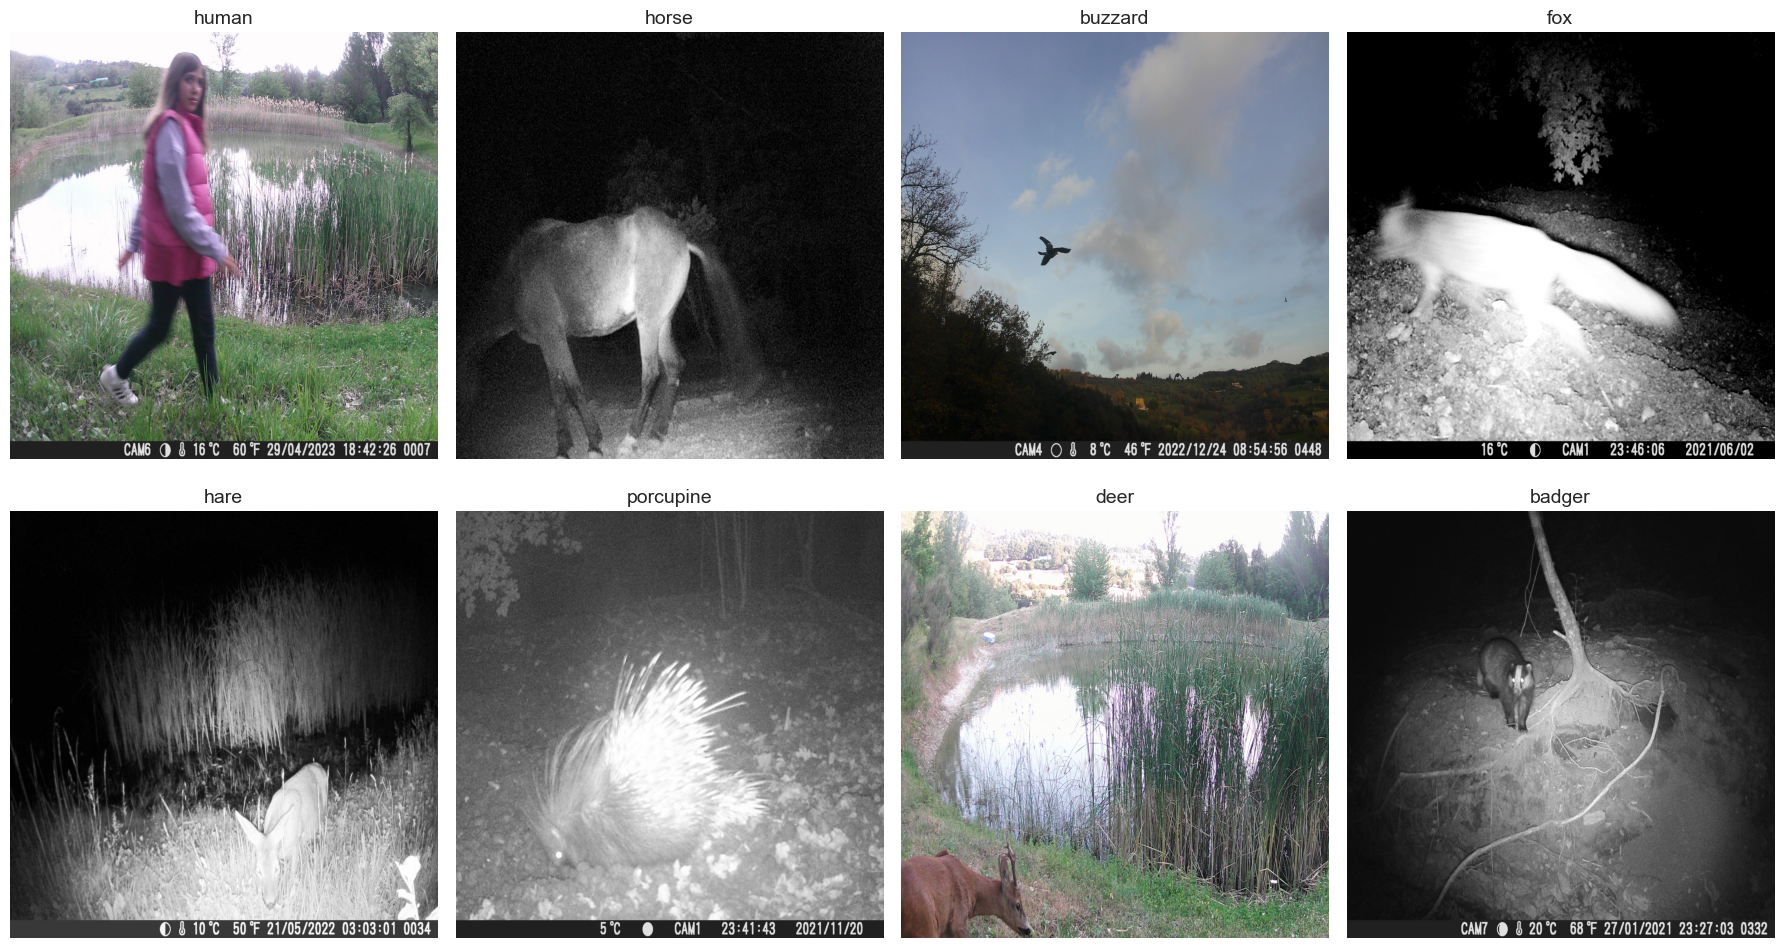

In [6]:
# Ensure we have at least 8 unique samples
subset = df[~df['cam'].isna()].sample(200).drop_duplicates(subset=['predicted_animal'], keep='last').sample(8).reset_index()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for i, row in subset.iterrows():
    path = os.path.join(image_folder, row.cam, row.image_name) if os.path.exists(
        os.path.join(image_folder, row.cam, row.image_name)) else None

    if path is None:
        path = os.path.join(image_folder, "experience", row.image_name)

    img = Image.open(path)
    img = img.resize((2048, 2048))
    ax = axes[i // 4, i % 4]
    ax.imshow(img)
    ax.title.set_text(row.predicted_animal)
    ax.axis('off')

plt.tight_layout()
plt.show()

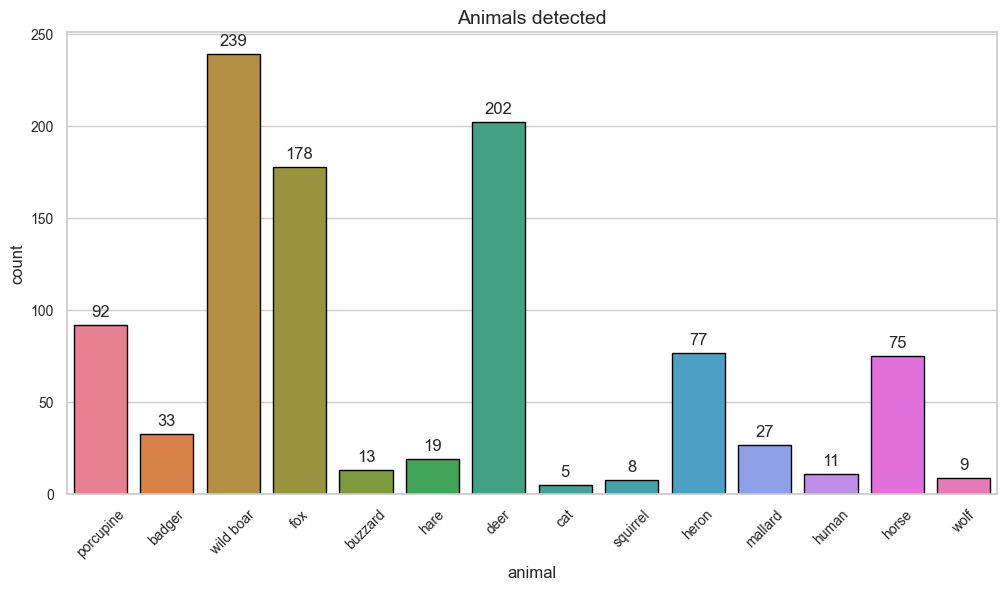

In [7]:
f, ax = plt.subplots()
c = sns.countplot(df, x="predicted_animal", hue="predicted_animal", legend=False, ec="black", ax=ax)

for p in c.patches:
    c.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')

ax.set_title('Animals detected')
ax.set_xlabel('animal')
ax.set_ylabel('count')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# c.axes.margins(.05)
# sns.despine(trim=True)
plt.show()

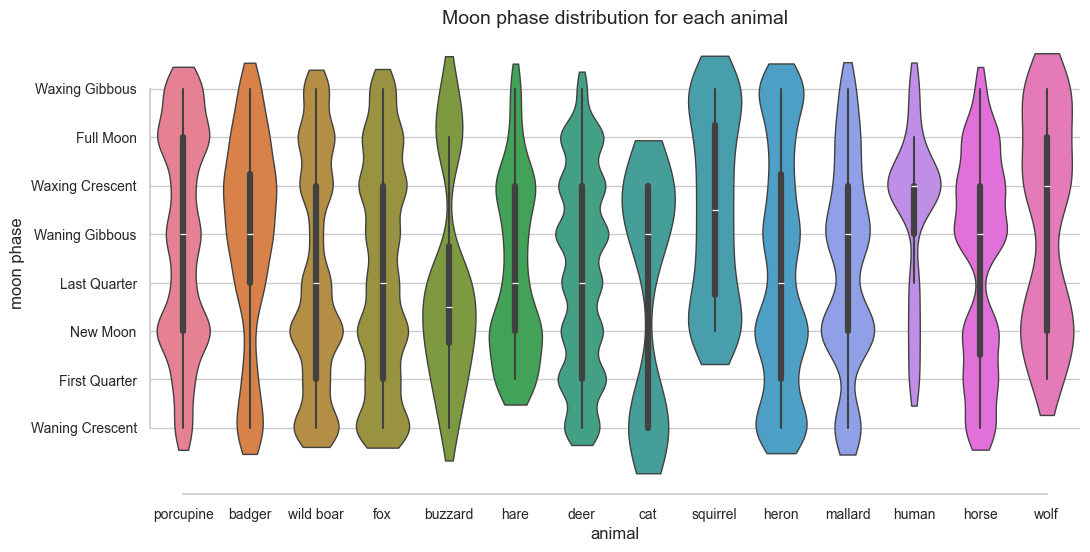

In [ ]:
f, ax = plt.subplots()

v = sns.violinplot(data=df, hue="predicted_animal", x="predicted_animal", y="moon_phase", 
               bw_adjust=.5, cut=1, linewidth=1, legend=False, ax=ax)

ax.set_ylabel('moon phase')
ax.set_xlabel('animal')

sns.despine(trim=True)
plt.title('Moon phase distribution for each animal')
plt.show()

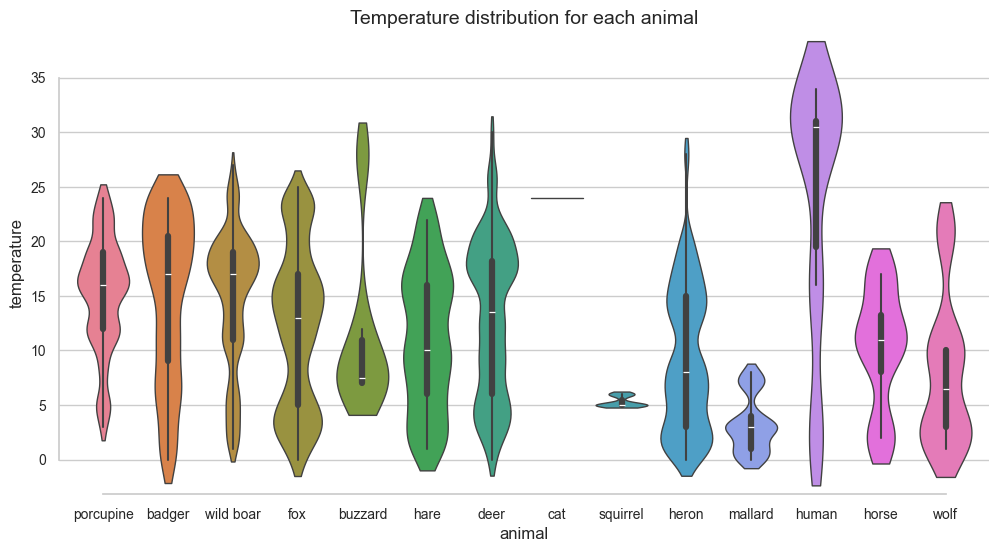

In [9]:
f, ax = plt.subplots()

v = sns.violinplot(data=df, hue="predicted_animal", x="predicted_animal", y="temperature", 
               bw_adjust=.5, cut=1, linewidth=1, legend=False, ax=ax)

ax.set_ylabel('temperature')
ax.set_xlabel('animal')

v.axes.margins(.02)

sns.despine(trim=True)
plt.title('Temperature distribution for each animal')
plt.show()

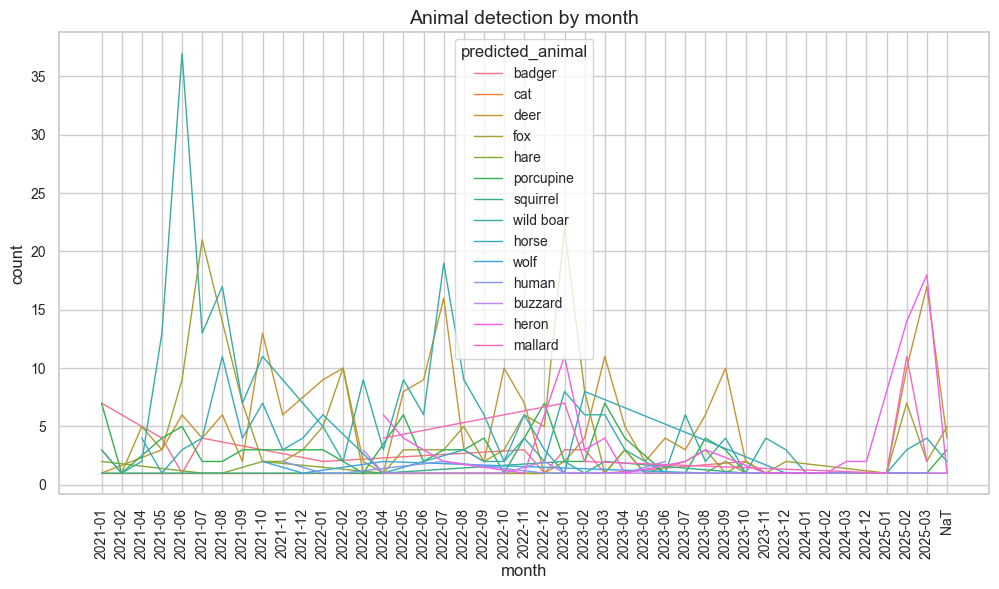

In [10]:
dd = df.copy()
dd['day'] = dd.date.dt.date
dd['month'] = dd.date.dt.to_period('M').astype(str)
dd = dd.groupby(['month', 'predicted_animal']).size().reset_index(name='count')

f, ax = plt.subplots()

sns.lineplot(x="month", y="count",
             hue="predicted_animal",
             data=dd)

plt.xticks(rotation=90)
plt.title('Animal detection by month')
plt.show()

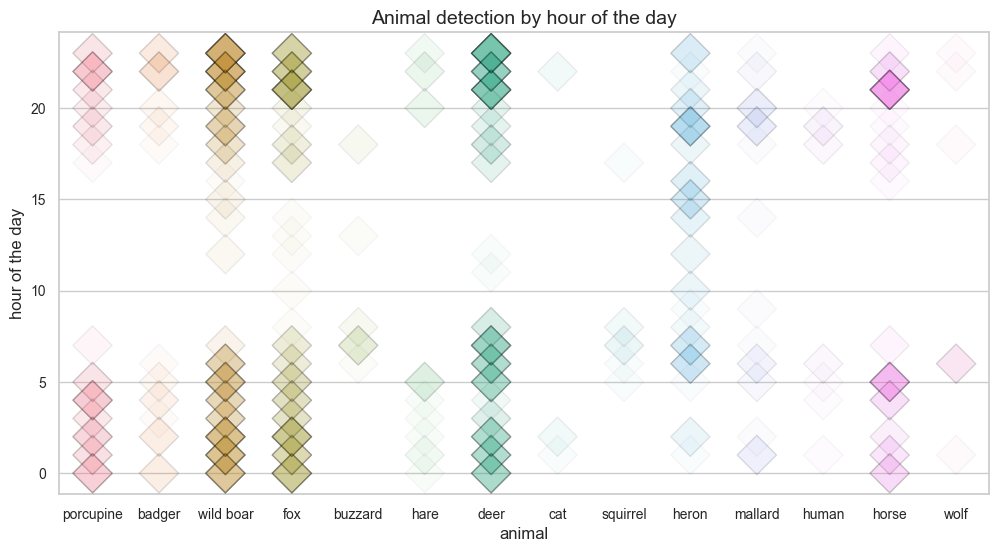

In [11]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['hour'] = df['date'].dt.hour

f, ax = plt.subplots()

c = sns.stripplot(data=df, x="predicted_animal", y="hour", hue="predicted_animal", 
                  edgecolor='black', ax=ax, legend=False, jitter=False, s=20, marker="D", linewidth=1, alpha=.03,)   

ax.set_ylabel('hour of the day')
ax.set_xlabel('animal')

# v.axes.margins(.05)

c.figure.set_size_inches(12, 6)

plt.title('Animal detection by hour of the day')
plt.show()

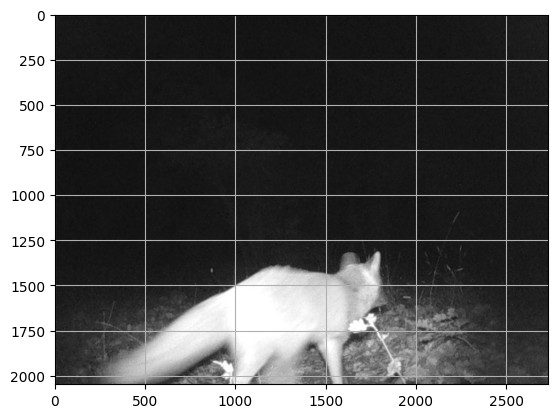

In [9]:
from PIL import Image

image_path = "images/archive/CAM 3/IMAG0003.jpg"
img = Image.open(image_path)
plt.imshow(img)
plt.grid('on')
plt.show()

In [12]:
# from transformers import pipeline

# checkpoint = "openai/clip-vit-large-patch14"

# detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

# candidate_labels = ["porcupine", "wild boar", "fox", "hare", "deer", 
#                     "badger", "wolf", "horse", "dog", "cat", "buzzard", "heron", "mallard", "squirrel",
#                     "human", "girl", "man", "woman", "old woman", "boy", "old man", "person", "people"]

In [13]:
# def ishuman(label):
#     return label in ["human", "girl", "man", "woman", "old woman", "boy", "old man", "person", "people"]

In [14]:
# # extract a random image
# random_row = df[df['cam'].notna()].sample(1)

# if random_row.cam is not None:
#     path = os.path.join(image_folder, random_row.cam.iloc[0], random_row.image_name.iloc[0])
# else:
#     path = os.path.join(image_folder, "experience", random_row.image_name.iloc[0])

# # image = Image.open(path)
# # image = Image.open("images-compressed/CAM7/TF_ACULEI_24092022-17969.jpg")
# # image = Image.open("images-compressed/CAM4/TF_ACULEI_03012023-21462.jpg")
# image = Image.open("images-compressed/CAM7/TF_ACULEI_12012021-85.jpg")

# predictions = detector(image, candidate_labels=candidate_labels)
# print(predictions[:3])

# fig, ax = plt.subplots(figsize=(6, 6))
# plt.imshow(image)

# top_predictions = predictions[:3]

# # in top predictions replace the human labels with 'human'
# for pred in top_predictions:
#     if ishuman(pred['label']):
#         pred['label'] = 'human'

# title = ' '.join([f"{pred['label']}: {pred['score']:.3f}%" for pred in top_predictions])

# plt.title(title, fontsize=12, fontweight='bold', color='darkblue')

# plt.tight_layout()
# plt.show()